In [1]:
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset as BaseDataset, DataLoader
from ImageLoader import ImageLoader2D
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import os
from segmentation_models_pytorch import utils
import torch
from tqdm import tqdm

In [2]:
# data settings
img_size = 256
dataset_type = "psfhs"
random_seed = 42

# model settings
ENCODER = "resnet34"
ENCODER_WEIGHTS = "imagenet"
CLASSES = ["background", "ps", "fh"]
DEVICE = "cuda"
ACTIVATION = "softmax"
LR = 0.00001

In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(" ".join(name.split("_")).title())
        plt.imshow(image, cmap="grey")
    plt.show()

In [4]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = [
        "background",
        "ps",
        "fh",
    ]

    def __init__(
        self,
        images,
        masks,
        classes=[],
        augmentation=None,
        preprocessing=None,
    ):
        self.images = images
        self.masks = masks
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = self.images[i]
        mask = self.masks[i]

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype("float")

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        return image, mask

    def __len__(self):
        return len(self.images)

In [5]:
X, Y = ImageLoader2D.load_data(img_size, img_size, -1, dataset_type)

Resizing training images and masks: 1358


0it [00:00, ?it/s]

1358it [00:11, 118.58it/s]


In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=random_seed, shuffle=True
)
x_test, x_valid, y_test, y_valid = train_test_split(
    x_test, y_test, test_size=0.5, random_state=random_seed, shuffle=True
)

print("train size (%80): ", x_train.shape)
print("valid size (%10): ", x_valid.shape)
print("test size (%10): ", x_test.shape)

train size (%80):  (1086, 256, 256, 3)
valid size (%10):  (136, 256, 256, 3)
test size (%10):  (136, 256, 256, 3)


In [7]:
import albumentations as albu

In [8]:
def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(
            scale_limit=0.5,
            rotate_limit=0,
            shift_limit=0.1,
            p=1,
            border_mode=0,
            value=0,
        ),
        albu.PadIfNeeded(
            min_height=None,
            min_width=None,
            pad_height_divisor=32,
            pad_width_divisor=32,
            always_apply=True,
            border_mode=0,
            value=0,
        ),
        # albu.RandomCrop(height=, width=320, always_apply=True),
        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [albu.PadIfNeeded(img_size, img_size)]
    return albu.Compose(test_transform)


def to_tensor_image(x, **kwargs):
    return (x / 255).transpose(2, 0, 1).astype("float32")


def to_tensor_mask(x, **kwargs):
    return x.transpose(2, 0, 1).astype("float32")


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=to_tensor_image, mask=to_tensor_mask),
    ]
    return albu.Compose(_transform)

In [9]:
model = smp.Unet(
    encoder_name=ENCODER,  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    # encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    activation=ACTIVATION,
    in_channels=3,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=len(CLASSES),  # model output channels (number of classes in your dataset)
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

(3, 256, 256) (3, 256, 256)


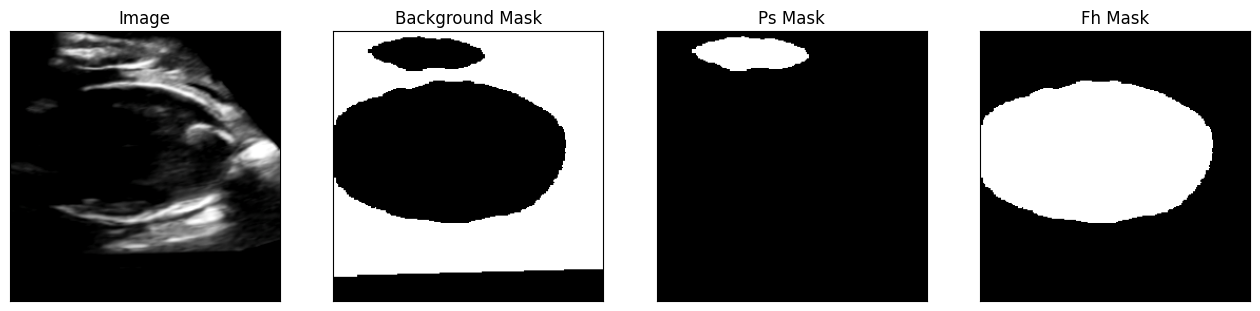

In [10]:
train_dataset = Dataset(
    x_train,
    y_train,
    classes=["background", "ps", "fh"],
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)
valid_dataset = Dataset(
    x_valid,
    y_valid,
    classes=["background", "ps", "fh"],
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)
test_dataset = Dataset(
    x_test,
    y_test,
    classes=["background", "ps", "fh"],
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

image, masks = train_dataset[42]
print(image.shape, masks.shape)

visualize(
    image=np.transpose(image, (1, 2, 0)),
    background_mask=masks.squeeze()[0, :, :],
    ps_mask=masks.squeeze()[1, :, :],
    fh_mask=masks.squeeze()[2, :, :],
)

In [11]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.Precision(),
    smp.utils.metrics.Recall(),
    smp.utils.metrics.Accuracy(),
    smp.utils.metrics.Fscore(),
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam(
    [
        dict(params=model.parameters(), lr=LR),
    ]
)

In [12]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [13]:
max_score = 0

for i in range(0, 30):

    print("\nEpoch: {}".format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs["iou_score"]:
        max_score = valid_logs["iou_score"]
        torch.save(model, "./best_model.pth")
        print("Model saved!")

    if i == 25:
        optimizer.param_groups[0]["lr"] = 1e-5
        print("Decrease decoder learning rate to 1e-5!")


Epoch: 0
train:   0%|          | 0/136 [00:00<?, ?it/s]

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


valid: 100%|██████████| 136/136 [00:03<00:00, 34.15it/s, dice_loss - 0.538, precision - 0.6994, recall - 0.3741, accuracy - 0.738, fscore - 0.4869, iou_score - 0.3234]  
Model saved!

Epoch: 1
valid: 100%|██████████| 136/136 [00:03<00:00, 34.96it/s, dice_loss - 0.3696, precision - 0.8945, recall - 0.7589, accuracy - 0.8899, fscore - 0.821, iou_score - 0.6984] 
Model saved!

Epoch: 2
valid: 100%|██████████| 136/136 [00:03<00:00, 34.44it/s, dice_loss - 0.2714, precision - 0.9183, recall - 0.8591, accuracy - 0.9276, fscore - 0.8877, iou_score - 0.7998]
Model saved!

Epoch: 3
valid: 100%|██████████| 136/136 [00:04<00:00, 33.66it/s, dice_loss - 0.2178, precision - 0.9455, recall - 0.9045, accuracy - 0.9508, fscore - 0.9245, iou_score - 0.8608]
Model saved!

Epoch: 4
valid: 100%|██████████| 136/136 [00:04<00:00, 32.81it/s, dice_loss - 0.1636, precision - 0.9558, recall - 0.9355, accuracy - 0.9641, fscore - 0.9455, iou_score - 0.8974]
Model saved!

Epoch: 5
valid: 100%|██████████| 136/136 [00

In [14]:
model = torch.load("./best_model.pth")

test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [15]:
test_epoch.run(test_loader)

valid: 100%|██████████| 136/136 [00:03<00:00, 37.85it/s, dice_loss - 0.03235, precision - 0.9771, recall - 0.9766, accuracy - 0.9845, fscore - 0.9768, iou_score - 0.955] 


{'dice_loss': 0.03235359796706368,
 'precision': 0.9770607361022162,
 'recall': 0.97656810984892,
 'accuracy': 0.9845468682401322,
 'fscore': 0.9768143572351509,
 'iou_score': 0.954961192958495}

torch.Size([1, 3, 256, 256])


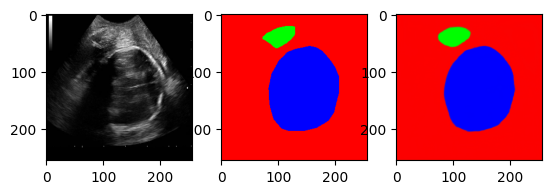

In [37]:
for x, y in test_loader:
    x, y = x.to(DEVICE), y.to(DEVICE)
    pred = model.predict(x)
    print(pred.shape)
    fix, axis = plt.subplots(1, 3)

    
    axis[0].imshow(np.transpose(x[0].cpu(), (1, 2, 0)))
    axis[1].imshow(np.transpose(y[0].cpu(), (1, 2, 0)))
    axis[2].imshow(np.transpose(pred[0].cpu(), (1, 2, 0)), cmap="grey")
    
    plt.show()
    break

(3, 256, 256)


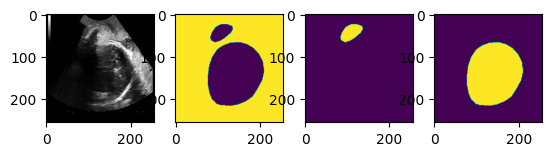

In [18]:
image, masks = test_dataset[3]

fig, axis = plt.subplots(1, 4)
axis[0].imshow(np.transpose(image, (1, 2, 0)))
axis[1].imshow(masks[0])
axis[2].imshow(masks[1])
axis[3].imshow(masks[2])